In [38]:
# GAN(generative adversarial network), DCGAN(deep convolution generative adversarial network)

## ✳ GAN
> 1. 두 종류의 신경망 준비 : 화상을 생성하는 `신경망 생성기(Generator, G)`와 생성된 가짜 화상인지 훈련 데이터로 준비한 화상인지 분류하는 `신경망 식별기(Discriminator, D)`
> 2. G는 D를 속이기 위해 훈련 데이터에 가까운 화상을 생성하도록 학습하고, D는 G에 속지 않고 진위를 가려내도록 학습
> 3. 이를 통해 최종적으로 G가 현실에 존재할 만한 화상을  생성

# MNIST 필기체 숫자 생성하기

---

## ✳  Generator Mechanism 
### Ganerator(G) 의 역할
> * 생성할 화상은 64x64 크기, 채널은 흑백 1채널로 0~255단계의 256단계 값으로 함. 화상은 64x64 = 4,096 픽셀을 가지며, 각 256단계이므로
256의 4,096승 화상 패턴이 존재하게 됨. 사람이 봤을 때 숫자로 보이는 패턴을 생성하는 것이 G의 역할
> * 다양한 패턴 화상을 생성하기 위해 G 신경망의 입력 데이터는 다양한 패턴을 생성할 난수를 입력함. 난수 값에 따라 G가 숫자 화상을 출력
> * G에 필기체 숫자의 화상을 출력하기 위해서는 지도 데이터가 필요함. 사람이 봤을 때 숫자로 보이는 화상ㅇ르 지도 데이터로 G에 제공.
즉, 256의 4,096승 패턴의 화상 중 사람이 봤을 때 필기체 숫자인 일부 지도 데이터의 화상을 단서로, 사람이 봣을 때 필기체 숫자로 보이는 패턴의 규칙을 G가 기억하게 됨. G는 규칙(학습한 신경망의 결합 파라미터)과 입력 난수에서 화상을 생성

## Generator 구현
---
> 전치 합성곱 ConvTranspose2d를 사용한 G 구현

- G는 ConvTranspose2d, 배치 정규화, ReLU 를 1세트로 한 레이어를 4회 반복하여 특징량 크기를 서서히 늘림.
- 각 레이어에서 최초 레이어만큼 채널 수를 많이 잡은 전치 합성곱으로 조금씩 채널 수를 줄임. 네 개의 레이어를 통과한 뒤, 
마지막으로 ConvTranspose2d의 출력 채널 수를 1 (흑백 화상의 채널 수 1에 해당)로 함. 활성화 함수는 Tanh로 하여 -1부터 1까지 출력하는 
출력 레이어를 생성. 변수 z는 입력 난수를 나타냄.
- 입력 난수 차원은 z_dim=20으로 함

In [39]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [40]:
class Generator(nn.Module) :
    def __init__(self, z_dim=20, image_size=64) :
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(z_dim, image_size * 8,
                                    kernel_size=4, stride=1),
                        nn.BatchNorm2d(image_size * 8),
                        nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(image_size * 8, image_size *4,
                                    kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(image_size * 4),
                                    
                                   nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(image_size *4, image_size*2,
                                    kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(image_size *2),
                    nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(image_size * 2, image_size,
                                    kernel_size=4, stride=2, padding=1),
                        nn.BatchNorm2d(image_size),
                        nn.ReLU(inplace=True))
        self.last = nn.Sequential(nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                                    stride=2, padding=1),
                nn.Tanh())
        
        # 주의 ! 흑백 화상이므로 출력 채널은 하나임.
        
    def forward(self, z) :
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)        
        out = self.layer4(out)
        out = self.last(out)
        
        return out

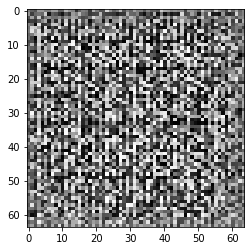

In [62]:
# 구현한 G로 화상을 생성하기

# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기 (1, 20, 1, 1)로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상 출력
fake_images= G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

## ✳  Discriminator Mechanism
- G와 마찬가지로 4개의 `layer`와 `last`의 총 다섯개 레이어로 구성

In [42]:
class Discriminator(nn.Module) :
    def __init__(self, z_dim=20, image_size=64) :
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(1, image_size, kernel_size=4,
                                             stride=2, padding=1),
                                    nn.LeakyReLU(0.1, inplace=True))
        # 주의 ! 흑백 화상이므로 입력 채널은 하나 뿐이다.

        self.layer2 = nn.Sequential(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1),
                                   nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [56]:
# G에서 가짜 화상을 생성한 후 D에 입력하여 판단 
# (G에서 생성된 가짜 화상이면 라벨 0, 지도 데이터면 라벨 1)
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out = D(fake_images)

# 출력 d_out에 시그모이드를 곱하여 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[[[0.4988]]]], grad_fn=<SigmoidBackward>)


## DCGAN의 손실함수, 학습, 생성
---
## ✳ GAN의 손실함수
### D의 손실함수
> 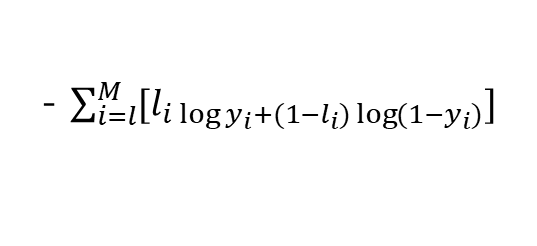
> D는 G의 화상을 정확히 판정하기 위하여 상단의 식을 최소화 하려 함. 반대로 G는 식을 최대화 하려고 함
> - `torch.nn.BCEWithLogitsLoss()`로 구현 

In [44]:
# # D 오차 함수의 이미지 구현
# # maximize log(D(x)) + log(1 - D(G(z)))

# # ※ x가 정의되지 않아 오류 발생
# # ------------------

# # 정답 라벨 작성
# mini_batch_size = 2
# label_real = torch.full((mini_batch_size,), 1)

# # 가짜 라벨 작성
# label_fake = torch.full((mini_batch_size,), 0)

# # 오차 함수 정의
# criterion = nn.BCEWithLogitsLoss(reduction='mean')

# # 진짜 화상 판정
# d_out_real = D(x)

# # 가짜 화상을 생성하여 판정
# input_z = torch.randn(mini_batch_size, 20)
# input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
# fake_images = G(input_z)
# d_out_fake = D(fake_images)

# # 오차 계산
# d_loss_real = criterion(d_out_real.view(-1), label_real)
# d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
# d_loss = d_loss_real + d_loss_fake

### G의 손실함수
> 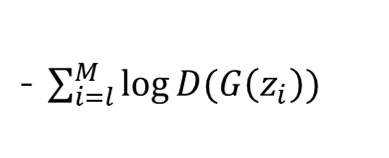
> `criterion(d_out_fake.view(-1), label_real)`로 구현

In [45]:
# # G의 오차 함수 이미지 구현
# # maximize log(D(G(z)))

# # ※ x가 정의되지 않아 오류 발생
# # -----------------

# # 가짜 화상을 생성해 판정
# input_z = torch.randn(mini_batch_size, 20)
# input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
# fake_images = G(input_z)
# d_out_fake = D(fake_images)

# # 오차 계산
# g_loss = criterion(d_out_fake.view(-1), label_real)

## ✳  데이터 로더 작성

In [46]:
def make_datapath_list() :
    '''학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성'''
    
    train_img_list = list() # 화상 파일 경로 저장
    
    for img_idx in range(200) :
        img_path = './pytorch_advanced/gan_generation/data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './pytorch_advanced/gan_generation/data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [47]:
class ImageTransform() :
    '''화상 전처리 클래스'''
    
    def __init__(self, mean, std) :
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
    def __call__(self, img) :
        return self.data_transform(img)

In [48]:
class GAN_Img_Dataset(data.Dataset) :
    '''화상의 데이터셋 클래스, 파이토치의 데이터셋 클래스를 상속'''
    
    def __init__(self, file_list, transform) :
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self) :
        '''화상 매수 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index) :
        '''전처리 화상의 텐서 형식 데이터 취득'''
        
        img_path = self.file_list[index]
        img = Image.open(img_path) # [높이][폭]
        
        # 화상 전처리
        img_transformed = self.transform(img)
        
        return img_transformed

In [49]:
# 데이터 로더 작성과 동작 확인

# 파일 리스트 작성
train_img_list = make_datapath_list()

# 데이터셋 작성
mean = (0.5, )
std = (0.5, )

train_dataset = GAN_Img_Dataset(file_list=train_img_list,
                               transform=ImageTransform(mean, std))

# 데이터 로더 작성
batch_size=  64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
# 동작 확인
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 첫 번째 요소를 꺼냄
print(images.size()) # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


## ✳  DCGAN 학습

In [50]:
# 네트워크 초기화
# --> 전치합성곱과 합성곱 층의 가중치는 평균 0, 표준편차 0.02의 정규 분포로,
# 배치 정규화의 가중치는 평균 1, 표준편차 0.02의 정규 분포를 따르도록 초기화
# 각 바이어스 항은 초기는 0으로 함.
def weights_init(m) : 
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        # Conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    elif classname.find('BatchNorm') != -1 :
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print('네트워크 초기화 완료!')

네트워크 초기화 완료!


In [65]:
# 모델을 학습시키는 함수 작성
def train_model(G, D, dataloader, num_epochs) :
    
    # GPU를 사용할 수 있는지 확인
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('사용 장치 :', device)
    
    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 오차 함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # 파라미터를 하드 코딩
    z_dim = 20
    mini_batch_size = 64
    
    # 네트워크를 GPU로
    G.to(device)
    D.to(device)
    
    G.train() # 모델을 훈련 모드로
    D.train() # 모델을 훈련 모드로
    
    # 네트워크가 어느정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 화상 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # 반복 카운터 설정
    iteration = 1
    logs = []
    
    # 에폭 루프
    for epoch in range(num_epochs) :
        # 개시 시간 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0 # 에폭의 손실 합
        epoch_d_loss = 0.0 # 에폭의 손실 합
        
        print('-' * 20) 
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 20) 
        print(' (train) ')
        
        # 데이터 로더에서 미니 배치씩 꺼내는 루프
        for images in dataloader :
            
            # -----------------------
            # 1. Discriminator 학습
            # -----------------------
            # 미니 배치 크기가 1이면 배치 정규화해서 오류가 발생하므로 피함
#             if images.size()[0] == 1 :
#                 continue
                
            # GPU를 사용할 수 있다면 GPU로 데이터를 보냄
            images = images.to(device)
            
            # 정답 라벨과 가짜 라벨 작성
            # 에폭의 마지막 반복은 미니배치 수가 줄어듦
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size, ), 0).to(device)
            
            # 진짜 화상 판정
            d_out_real = D(images)
            
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 오차 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # 역전파 
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            # -----------------------
            # 2. Generator 학습
            # -----------------------
            # 가짜 화상을 생성하여 판정
            input_z = torch.rand(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 오차 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # 에폭의 phase별 손실과 정답률
        t_epoch_finish = time.time()
        print('-' * 20) 
        print(f'Epcoh {epoch} || Epoch_D_Loss : {epoch_d_loss / batch_size :.4f} || \
                Epoch_G_Loss : {epoch_g_loss/batch_size:.4f}')
        print(f'Timer : {t_epoch_finish - t_epoch_start:.4f} sec')
        t_epoch_start = time.time()
            
    return G, D

In [66]:
# 학습 및 검증 실행
num_epochs = 200
G_update, D_update = train_model(G, D, dataloader=train_dataloader,
                                num_epochs=num_epochs)

사용 장치 : cpu
--------------------
Epoch 0/200
--------------------
 (train) 
--------------------
Epcoh 0 || Epoch_D_Loss : 0.1348 ||                 Epoch_G_Loss : 0.4092
Timer : 13.4959 sec
--------------------
Epoch 1/200
--------------------
 (train) 
--------------------
Epcoh 1 || Epoch_D_Loss : 0.0033 ||                 Epoch_G_Loss : 0.0524
Timer : 13.4022 sec
--------------------
Epoch 2/200
--------------------
 (train) 
--------------------
Epcoh 2 || Epoch_D_Loss : 0.0010 ||                 Epoch_G_Loss : 0.0279
Timer : 13.2466 sec
--------------------
Epoch 3/200
--------------------
 (train) 
--------------------
Epcoh 3 || Epoch_D_Loss : 0.0010 ||                 Epoch_G_Loss : 0.0315
Timer : 13.3204 sec
--------------------
Epoch 4/200
--------------------
 (train) 
--------------------
Epcoh 4 || Epoch_D_Loss : 0.0720 ||                 Epoch_G_Loss : 0.0929
Timer : 13.5518 sec
--------------------
Epoch 5/200
--------------------
 (train) 
--------------------
Epcoh 5 

--------------------
Epcoh 45 || Epoch_D_Loss : 0.0204 ||                 Epoch_G_Loss : 0.1890
Timer : 13.1119 sec
--------------------
Epoch 46/200
--------------------
 (train) 
--------------------
Epcoh 46 || Epoch_D_Loss : 0.0623 ||                 Epoch_G_Loss : 0.3640
Timer : 13.0411 sec
--------------------
Epoch 47/200
--------------------
 (train) 
--------------------
Epcoh 47 || Epoch_D_Loss : 0.0259 ||                 Epoch_G_Loss : 0.2721
Timer : 13.0182 sec
--------------------
Epoch 48/200
--------------------
 (train) 
--------------------
Epcoh 48 || Epoch_D_Loss : 0.0155 ||                 Epoch_G_Loss : 0.3882
Timer : 13.0431 sec
--------------------
Epoch 49/200
--------------------
 (train) 
--------------------
Epcoh 49 || Epoch_D_Loss : 0.0282 ||                 Epoch_G_Loss : 0.5422
Timer : 13.1528 sec
--------------------
Epoch 50/200
--------------------
 (train) 
--------------------
Epcoh 50 || Epoch_D_Loss : 0.0857 ||                 Epoch_G_Loss : 0.5352

--------------------
Epcoh 91 || Epoch_D_Loss : 0.0145 ||                 Epoch_G_Loss : 0.3129
Timer : 13.4715 sec
--------------------
Epoch 92/200
--------------------
 (train) 
--------------------
Epcoh 92 || Epoch_D_Loss : 0.0248 ||                 Epoch_G_Loss : 0.5646
Timer : 13.7151 sec
--------------------
Epoch 93/200
--------------------
 (train) 
--------------------
Epcoh 93 || Epoch_D_Loss : 0.0149 ||                 Epoch_G_Loss : 0.4274
Timer : 13.3972 sec
--------------------
Epoch 94/200
--------------------
 (train) 
--------------------
Epcoh 94 || Epoch_D_Loss : 0.0127 ||                 Epoch_G_Loss : 0.4094
Timer : 13.0850 sec
--------------------
Epoch 95/200
--------------------
 (train) 
--------------------
Epcoh 95 || Epoch_D_Loss : 0.0201 ||                 Epoch_G_Loss : 0.5641
Timer : 13.6596 sec
--------------------
Epoch 96/200
--------------------
 (train) 
--------------------
Epcoh 96 || Epoch_D_Loss : 0.0090 ||                 Epoch_G_Loss : 0.4341

--------------------
Epcoh 136 || Epoch_D_Loss : 0.0220 ||                 Epoch_G_Loss : 0.5299
Timer : 13.1768 sec
--------------------
Epoch 137/200
--------------------
 (train) 
--------------------
Epcoh 137 || Epoch_D_Loss : 0.0079 ||                 Epoch_G_Loss : 0.4214
Timer : 13.1658 sec
--------------------
Epoch 138/200
--------------------
 (train) 
--------------------
Epcoh 138 || Epoch_D_Loss : 0.0147 ||                 Epoch_G_Loss : 0.1748
Timer : 13.1708 sec
--------------------
Epoch 139/200
--------------------
 (train) 
--------------------
Epcoh 139 || Epoch_D_Loss : 0.0070 ||                 Epoch_G_Loss : 0.2286
Timer : 12.9833 sec
--------------------
Epoch 140/200
--------------------
 (train) 
--------------------
Epcoh 140 || Epoch_D_Loss : 0.0074 ||                 Epoch_G_Loss : 0.4587
Timer : 13.1099 sec
--------------------
Epoch 141/200
--------------------
 (train) 
--------------------
Epcoh 141 || Epoch_D_Loss : 0.0043 ||                 Epoch_G_Lo

--------------------
Epcoh 181 || Epoch_D_Loss : 0.0072 ||                 Epoch_G_Loss : 0.3196
Timer : 12.9055 sec
--------------------
Epoch 182/200
--------------------
 (train) 
--------------------
Epcoh 182 || Epoch_D_Loss : 0.0167 ||                 Epoch_G_Loss : 0.2949
Timer : 12.9384 sec
--------------------
Epoch 183/200
--------------------
 (train) 
--------------------
Epcoh 183 || Epoch_D_Loss : 0.0028 ||                 Epoch_G_Loss : 0.2623
Timer : 12.9214 sec
--------------------
Epoch 184/200
--------------------
 (train) 
--------------------
Epcoh 184 || Epoch_D_Loss : 0.0013 ||                 Epoch_G_Loss : 0.6335
Timer : 12.9903 sec
--------------------
Epoch 185/200
--------------------
 (train) 
--------------------
Epcoh 185 || Epoch_D_Loss : 0.0223 ||                 Epoch_G_Loss : 0.7761
Timer : 12.9224 sec
--------------------
Epoch 186/200
--------------------
 (train) 
--------------------
Epcoh 186 || Epoch_D_Loss : 0.0018 ||                 Epoch_G_Lo

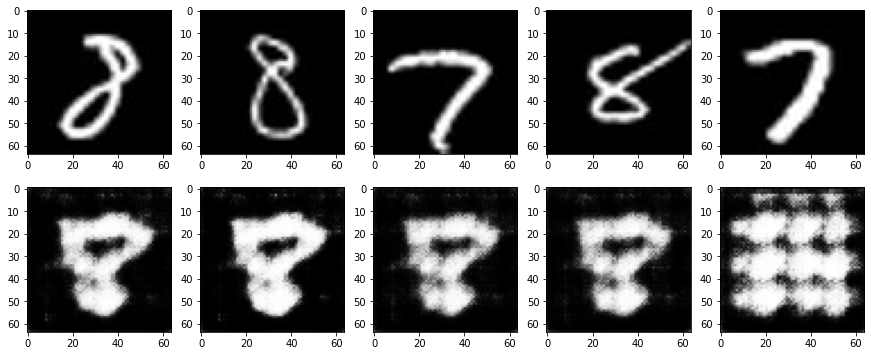

In [102]:
# 생성 화상과 훈련데이터 시각화
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지 재실행한다

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 첫 번째 요소를 꺼냄

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5) :
    # 상단에 훈련 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 하단에 생성 데이터 표시
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

In [ ]:
# 숫자의 지도 7,8만 200개씩 생성했을 때, 시간을 계속 늘리면 G는 7의 화상만 생성하게 됨
# --> 숫자 7이 8에 비해 단순하며 식별기 D를 속이는 화상 생성이 쉽기 때문
# : 이처럼 지도 데이터 일부만 생성하는 형상 `모드 붕괴`라고 함.